# 👋 Buy This!: Session-based Recommendation Using SR-GNN

Hi! This is the notebook for [the Medium tutorial](https://medium.com/@eunjeelynnsung/buy-this-session-based-recommendation-using-sr-gnn-d3415e393722) created for Stanford 2021 Fall CS224W class. If you have any questions, please email `ejsung [at] stanford.edu`.

I referred to following code bases while writing the code below.

- https://colab.research.google.com/drive/1X4uOWv_xkefDu_h-pbJg-fEkMfR7NGz9?usp=sharing
- https://github.com/userbehavioranalysis/SR-GNN_PyTorch-Geometric
- https://rzykov.github.io/notebooks/RetailRocketDatasetNextClick.html


# 👀 How to Use This Notebook

1. Download the original dataset from [here](https://www.kaggle.com/retailrocket/ecommerce-dataset).

2. Upload the `events.csv` file to the file system.

3. Make a folder called `raw` in the same directory.

4. Run the cells below!

# ⚙️ Set Up

In [ ]:
# Install torch geometric
# Code taken from 2021 Fall CS224W Colab assignments.
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
  !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 233 kB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 3.5 MB 12.1 MB/s 
     |████████████████████████████████| 325 kB 15.5 MB/s 
     |████████████████████████████████| 407 kB 55.9 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=b163a349f4958fbd1c267760ffd49f98048e386b8a1ed1560fb441d6a2c1f6f7
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


In [ ]:
# Import Python built-in libraries
import copy
import pickle
import random
import time

In [ ]:
# Import pip libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

# ⚗️ Data Preprocessing

## Download

You can download the data from 🔗[this kaggle competition](https://www.kaggle.com/retailrocket/ecommerce-dataset). We will only use the `events.csv` file.

## Inspection

Let's have a look at the dataset.

In [ ]:
# Load and have a peek into the dataset
events_df = pd.read_csv('events.csv')
print(events_df.head())
print(f'There are {len(events_df)} rows in the raw data.')

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
There are 2756101 rows in the raw data.


In [ ]:
# Print the summarized statistics of the dataset
events_df.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [ ]:
# Check the maximum unique id of items.
# We will use this as the total number of items to create item embeddings.
max(events_df['itemid'])

466867

## Separating log data into sessions

Let's load and break all log data into sessions for all users. Note that these preprocessing logics were taken from [here](https://rzykov.github.io/notebooks/RetailRocketDatasetNextClick.html) where the code is written in Scala.

Summary of what we do in the cell below:

1. Filter only the 'view' events. Among the three types of events provided by the dataset, we will only use the 'view' events to predict and recommend the next 'viewed' item.
2. Filter out visitors with single clicks.
3. Group events by visitor id.
4. Within the grouped events from a visitor, break and generate sessions

In [ ]:
# Filter only the 'view' events.
events_df_filtered = events_df[events_df['event'] == 'view']
print(f'There are {len(events_df_filtered)} `view` events in the raw data.')

There are 2664312 `view` events in the raw data.


In [ ]:
# Filter out visitors with single clicks.
visit_counts_per_visitor = events_df_filtered['visitorid'].value_counts(dropna=False)
visit_counts_per_visitor.head()

visitors_with_significant_visits = visit_counts_per_visitor[
    visit_counts_per_visitor > 1
].index
events_df_filtered = events_df_filtered[
    events_df_filtered['visitorid'].isin(visitors_with_significant_visits)]

In [ ]:
# Let's group events and their timing data.
visits_by_visitors = {}
for _, row in enumerate(tqdm(events_df_filtered.iterrows())):
    timestamp, visitorid, event, itemid, transactionid = row[1].values

    if visitorid not in visits_by_visitors:
        visits_by_visitors[visitorid] = {'itemids': [], 'timestamps': []}
    visits_by_visitors[visitorid]['itemids'].append(itemid)
    visits_by_visitors[visitorid]['timestamps'].append(timestamp)

print()
print(f'There are {len(visits_by_visitors)} visitors left.')

1656582it [01:57, 14156.47it/s]


There are 396449 visitors left.


In [ ]:
# We will separate sessions by 2 hours.
delay = 2 * 3600 * 1000

# Let's group events from visitors into sessions.
sessions_by_visitors = {}
for visitorid, visitor_dict in visits_by_visitors.items():
    sessions = [[]]
    events_sorted = sorted(zip(visitor_dict['timestamps'],
                               visitor_dict['itemids']))
    for i in range(len(events_sorted) - 1):
        sessions[-1].append(events_sorted[i][1])
        if (events_sorted[i+1][0] - events_sorted[i][0]) > delay:
            sessions.append([])
    sessions[-1].append(events_sorted[len(events_sorted) - 1][1])
    sessions_by_visitors[visitorid] = sessions

print()
print(f'There are {len(sessions_by_visitors)} sessions.')


There are 396449 sessions.


## Splitting train and test dataset

Now let's split the train, validation, and test dataset. We will split the dataset by user ids. Each user will only be found in one of the three splits! We split like this because the model may 'cheat' from partial sessions of a user during training and use that information during test time.

In [ ]:
# Adjsut sampling rate ([0, 1]) to generate smaller datasets.
# Setting `sampling_rate` to 1 will lead to a full dataset split.
sampling_rate = 1

# We use random seed for reproducibility.
seed = 42
all_visitors = list(sessions_by_visitors.keys())
random.Random(seed).shuffle(all_visitors)

num_train = int(len(all_visitors) * 0.8 * sampling_rate)
num_val = int(len(all_visitors) * 0.1 * sampling_rate)
num_test = int(len(all_visitors) * 0.1 * sampling_rate)

train_visitors = all_visitors[:num_train]
val_visitors = all_visitors[num_train : num_train+num_val]
test_visitors = all_visitors[num_train+num_val:num_train+num_val+num_test]

Let's check the size of each split and pickle the preprocessed data.

In [ ]:
def extract_subsessions(sessions):
    """Extracts all partial sessions from the sessions given.

    For example, a session (1, 2, 3) should be augemnted to produce two
    separate sessions (1, 2) and (1, 2, 3).
    """
    all_sessions = []
    for session in sessions:
        for i in range(1, len(session)):
            all_sessions.append(session[:i+1])
    return all_sessions

In [ ]:
# Check the number of visitors in each split
print(f'train, val, and test visitors: {len(train_visitors), len(val_visitors), len(test_visitors)}')

# Get sessions of each visitor, generate subsessions of each session, and put
# all the generated subsessions into right splits. We generate subsessions
# according to the dataset generation policy suggested by the original SR-GNN
# paper.
train_sessions, val_sessions, test_sessions = [], [], []
for visitor in train_visitors:
    train_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in val_visitors:
    val_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))
for visitor in test_visitors:
    test_sessions.extend(extract_subsessions(sessions_by_visitors[visitor]))

train, val, and test visitors: (317159, 39644, 39644)


In [ ]:
# Check the number of (sub)sessions in each split
print(f'train, val, and test sessions: {len(train_sessions), len(val_sessions), len(test_sessions)}')

# Save the processed files.
with open('raw/train.txt', 'wb') as f:
    pickle.dump(train_sessions, f)
with open('raw/val.txt', 'wb') as f:
    pickle.dump(val_sessions, f)
with open('raw/test.txt', 'wb') as f:
    pickle.dump(test_sessions, f)

train, val, and test sessions: (781928, 91317, 96896)


# 📦 Data Pipeline

For data ingestion, we use PyTorch's `dataloader` and PyG's `Data` class. To learn more about the `Data` class, check out the documentation [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#module-torch_geometric.data).

In [ ]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in sessions:
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor([senders, receivers], dtype=torch.long)
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

# 🔮 Model Design

Our gated session graph layer has two main parts: (1) message propagation to create an adjacency matrix (`self.propagate`) and (2) the GRU cell (`self.gru`). We will put these inside the `forward()` function.

We only use one layer for our `GatedSessionGraphConv` implementation for simplicity. Also, our sessions have average length < 5, so we do not need a large receptive field.

In [ ]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels

        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [ ]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        self.gated = GatedSessionGraphConv(self.hidden_size)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0)
        embedding = self.embedding(x).squeeze()

        # (1)-(5)
        v_i = self.gated(embedding, edge_index)

        # Divide nodes by session
        # For the detailed explanation of what is happening below, please refer
        # to the Medium blog post.
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # (6)
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # (7)
        s_l = v_n
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        # (8)
        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

# 🚂 Model Training

We can now start model training. The training pipeline code below was originally taken from the 2021 Fall CS224W Colab assignments and then modified to fit the model.

In [ ]:
# Define the hyperparameters.
# Code taken from 2021 Fall CS224W Colab assignments.
args = {
    'batch_size': 100,
    'hidden_dim': 32,
    'epochs': 100,
    'l2_penalty': 0.00001,
    'weight_decay': 0.1,
    'step': 30,
    'lr': 0.001,
    'num_items': 466868}

class objectview(object):
    def __init__(self, d): 
        self.__dict__ = d

args = objectview(args)

In [ ]:
def train(args):
    # Prepare data pipeline
    train_dataset = GraphDataset('./', 'train')
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    val_dataset = GraphDataset('./', 'val')
    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=args.batch_size,
                                     shuffle=False,
                                     drop_last=True)

    # Build model
    model = SRGNN(args.hidden_dim, args.num_items).to('cuda')

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.lr,
                                 weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step,
                                          gamma=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to('cuda')
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
          test_acc, top_k_acc = test(val_loader, model, is_validation=True)
          print(test_acc)
          test_accs.append(test_acc)
          top_k_accs.append(top_k_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
  
    return test_accs, top_k_accs, losses, best_model, best_acc, val_loader

In [ ]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Define K for Hit@K metrics.
    k = 20
    correct = 0
    top_k_correct = 0

    for _, data in enumerate(tqdm(loader)):
        data.to('cuda')
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            score = test_model(data)
            pred = score.max(dim=1)[1]
            label = data.y

        if save_model_preds:
          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('pred.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

        # We calculate Hit@K accuracy only at test time.
        if not is_validation:
            score = score.cpu().detach().numpy()
            for row in range(pred.size(0)):
                top_k_pred = np.argpartition(score[row], -k)[-k:]
                if label[row].item() in top_k_pred:
                    top_k_correct += 1
    
    if not is_validation:
        return correct / len(loader), top_k_correct / len(loader)
    else:
        return correct / len(loader), 0

Processing...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Processing...
Done!
  0%|          | 0/7819 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 913/913 [00:16<00:00, 53.99it/s]


12.874041621029573


100%|██████████| 913/913 [00:09<00:00, 99.75it/s]


14.012048192771084


100%|██████████| 913/913 [00:08<00:00, 102.69it/s]


15.364731653888281


100%|██████████| 913/913 [00:09<00:00, 100.74it/s]


16.207009857612267


100%|██████████| 913/913 [00:08<00:00, 101.69it/s]


16.657174151150056


100%|██████████| 913/913 [00:08<00:00, 102.57it/s]


17.02300109529025


100%|██████████| 913/913 [00:09<00:00, 99.45it/s] 


17.236582694414018


100%|██████████| 913/913 [00:11<00:00, 79.18it/s] 


17.387732749178532


100%|██████████| 913/913 [00:08<00:00, 101.89it/s]


17.568455640744798


100%|██████████| 913/913 [00:08<00:00, 101.68it/s]


17.753559693318728


100%|██████████| 913/913 [00:08<00:00, 102.33it/s]


17.872946330777655


100%|██████████| 913/913 [00:09<00:00, 99.45it/s] 


18.026286966046


100%|██████████| 913/913 [00:08<00:00, 101.47it/s]


18.086527929901425


100%|██████████| 913/913 [00:08<00:00, 102.05it/s]


18.178532311062433


100%|██████████| 913/913 [00:09<00:00, 98.55it/s]


18.323110624315444


100%|██████████| 913/913 [00:09<00:00, 99.72it/s]


18.350492880613363


100%|██████████| 913/913 [00:09<00:00, 98.94it/s] 


18.373493975903614


100%|██████████| 913/913 [00:09<00:00, 100.25it/s]


18.337349397590362


100%|██████████| 913/913 [00:08<00:00, 102.67it/s]


18.522453450164292


100%|██████████| 913/913 [00:09<00:00, 100.91it/s]


18.50273822562979


100%|██████████| 913/913 [00:08<00:00, 101.75it/s]


18.56407447973713


100%|██████████| 913/913 [00:08<00:00, 102.14it/s]


18.57064622124863


100%|██████████| 913/913 [00:08<00:00, 102.20it/s]


18.700985761226725


100%|██████████| 913/913 [00:09<00:00, 101.17it/s]


18.690032858707557


100%|██████████| 913/913 [00:09<00:00, 96.69it/s]


18.740416210295727


100%|██████████| 913/913 [00:09<00:00, 101.37it/s]


18.707557502738226


100%|██████████| 913/913 [00:09<00:00, 101.06it/s]


18.856516976998904


100%|██████████| 913/913 [00:09<00:00, 99.03it/s]


18.717415115005476


100%|██████████| 913/913 [00:08<00:00, 101.85it/s]


18.802847754654984


100%|██████████| 913/913 [00:09<00:00, 101.21it/s]


18.733844468784227


100%|██████████| 913/913 [00:11<00:00, 78.66it/s] 


21.266155531215773


100%|██████████| 913/913 [00:09<00:00, 100.75it/s]


21.43921139101862


100%|██████████| 913/913 [00:09<00:00, 98.68it/s]


21.55312157721796


100%|██████████| 913/913 [00:09<00:00, 100.39it/s]


21.585980284775466


100%|██████████| 913/913 [00:09<00:00, 100.50it/s]


21.613362541073386


100%|██████████| 913/913 [00:09<00:00, 99.02it/s]


21.59802847754655


100%|██████████| 913/913 [00:09<00:00, 97.93it/s]


21.558598028477547


100%|██████████| 913/913 [00:09<00:00, 98.19it/s]


21.5815991237678


100%|██████████| 913/913 [00:09<00:00, 98.89it/s]


21.55640744797371


100%|██████████| 913/913 [00:09<00:00, 100.34it/s]


21.58050383351588


100%|██████████| 913/913 [00:09<00:00, 97.60it/s]


21.545454545454547


100%|██████████| 913/913 [00:09<00:00, 96.59it/s]


21.55969331872946


100%|██████████| 913/913 [00:09<00:00, 96.61it/s]


21.5815991237678


100%|██████████| 913/913 [00:09<00:00, 97.44it/s]


21.58488499452355


100%|██████████| 913/913 [00:09<00:00, 98.46it/s]


21.552026286966047


100%|██████████| 913/913 [00:09<00:00, 96.54it/s]


21.59145673603505


100%|██████████| 913/913 [00:09<00:00, 99.30it/s]


21.53997809419496


100%|██████████| 913/913 [00:09<00:00, 97.45it/s]


21.57064622124863


100%|██████████| 913/913 [00:09<00:00, 96.78it/s]


21.54654983570646


100%|██████████| 913/913 [00:09<00:00, 97.61it/s]


21.548740416210297


100%|██████████| 913/913 [00:09<00:00, 99.26it/s]


21.562979189485212


100%|██████████| 913/913 [00:09<00:00, 97.24it/s]


21.562979189485212


100%|██████████| 913/913 [00:09<00:00, 96.81it/s]


21.518072289156628


100%|██████████| 913/913 [00:11<00:00, 76.23it/s]


21.53450164293538


100%|██████████| 913/913 [00:09<00:00, 97.78it/s]


21.53997809419496


100%|██████████| 913/913 [00:09<00:00, 97.16it/s]


21.52354874041621


100%|██████████| 913/913 [00:09<00:00, 99.51it/s]


21.44687842278204


100%|██████████| 913/913 [00:09<00:00, 98.09it/s]


21.441401971522453


100%|██████████| 913/913 [00:09<00:00, 96.19it/s]


21.3855421686747


100%|██████████| 913/913 [00:09<00:00, 97.64it/s]


21.349397590361445


100%|██████████| 913/913 [00:09<00:00, 95.67it/s]


21.848849945235486


100%|██████████| 913/913 [00:09<00:00, 97.13it/s]


21.960569550930998


100%|██████████| 913/913 [00:09<00:00, 98.18it/s]


22.02738225629792


100%|██████████| 913/913 [00:09<00:00, 98.51it/s]


22.05366922234392


100%|██████████| 913/913 [00:09<00:00, 99.16it/s]


22.072289156626507


100%|██████████| 913/913 [00:09<00:00, 99.14it/s]


22.06790799561884


100%|██████████| 913/913 [00:09<00:00, 98.12it/s]


22.04709748083242


100%|██████████| 913/913 [00:09<00:00, 99.78it/s]


22.039430449069002


100%|██████████| 913/913 [00:09<00:00, 97.32it/s]


22.035049288061337


100%|██████████| 913/913 [00:09<00:00, 100.16it/s]


22.052573932092006


100%|██████████| 913/913 [00:09<00:00, 97.42it/s]


22.059145673603506


100%|██████████| 913/913 [00:09<00:00, 98.42it/s]


22.038335158817087


100%|██████████| 913/913 [00:09<00:00, 99.50it/s] 


22.038335158817087


100%|██████████| 913/913 [00:09<00:00, 100.70it/s]


22.028477546549837


100%|██████████| 913/913 [00:09<00:00, 100.55it/s]


22.01423877327492


100%|██████████| 913/913 [00:09<00:00, 100.98it/s]


22.002190580503832


100%|██████████| 913/913 [00:09<00:00, 97.94it/s]


21.997809419496168


100%|██████████| 913/913 [00:09<00:00, 96.12it/s]


21.987951807228917


100%|██████████| 913/913 [00:09<00:00, 99.85it/s] 


21.978094194961663


100%|██████████| 913/913 [00:09<00:00, 98.30it/s]


21.96933187294633


100%|██████████| 913/913 [00:09<00:00, 99.16it/s]


21.947426067907994


100%|██████████| 913/913 [00:09<00:00, 96.60it/s]


21.93209200438116


100%|██████████| 913/913 [00:09<00:00, 95.73it/s]


21.91237677984666


100%|██████████| 913/913 [00:09<00:00, 97.08it/s]


21.91566265060241


100%|██████████| 913/913 [00:09<00:00, 97.25it/s]


21.89923329682366


100%|██████████| 913/913 [00:09<00:00, 95.37it/s]


21.89594742606791


100%|██████████| 913/913 [00:10<00:00, 90.24it/s]


21.88937568455641


100%|██████████| 913/913 [00:09<00:00, 94.54it/s]


21.870755750273823


100%|██████████| 913/913 [00:09<00:00, 94.56it/s]


21.859802847754654


100%|██████████| 913/913 [00:09<00:00, 96.83it/s]


21.830230010952903


100%|██████████| 913/913 [00:09<00:00, 96.97it/s]


21.859802847754654


100%|██████████| 913/913 [00:09<00:00, 97.13it/s]


21.86199342825849


100%|██████████| 913/913 [00:09<00:00, 95.24it/s]


21.859802847754654


100%|██████████| 913/913 [00:09<00:00, 93.93it/s]


21.869660460021905


100%|██████████| 913/913 [00:10<00:00, 91.25it/s]


21.870755750273823


100%|██████████| 913/913 [00:09<00:00, 94.77it/s]


21.87513691128149


100%|██████████| 913/913 [00:09<00:00, 93.20it/s]


21.872946330777655


100%|██████████| 913/913 [00:09<00:00, 94.41it/s]


21.876232201533405


100%|██████████| 913/913 [00:09<00:00, 96.80it/s]


21.876232201533405


100%|██████████| 913/913 [00:09<00:00, 94.84it/s]


21.874041621029573
[12.874041621029573, 14.012048192771084, 15.364731653888281, 16.207009857612267, 16.657174151150056, 17.02300109529025, 17.236582694414018, 17.387732749178532, 17.568455640744798, 17.753559693318728, 17.872946330777655, 18.026286966046, 18.086527929901425, 18.178532311062433, 18.323110624315444, 18.350492880613363, 18.373493975903614, 18.337349397590362, 18.522453450164292, 18.50273822562979, 18.56407447973713, 18.57064622124863, 18.700985761226725, 18.690032858707557, 18.740416210295727, 18.707557502738226, 18.856516976998904, 18.717415115005476, 18.802847754654984, 18.733844468784227, 21.266155531215773, 21.43921139101862, 21.55312157721796, 21.585980284775466, 21.613362541073386, 21.59802847754655, 21.558598028477547, 21.5815991237678, 21.55640744797371, 21.58050383351588, 21.545454545454547, 21.55969331872946, 21.5815991237678, 21.58488499452355, 21.552026286966047, 21.59145673603505, 21.53997809419496, 21.57064622124863, 21.54654983570646, 21.548740416210297, 21

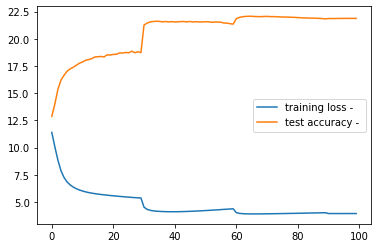

In [ ]:
test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train(args) 

print(test_accs, top_k_accs)
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
plt.show()

# 🧪 Evaluation

In [ ]:
# Save the best model
torch.save(best_model.state_dict(), 'model')

In [ ]:
# Run test for our best model to save the predictions!
test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  drop_last=True)

test(test_loader, best_model, is_validation=False, save_model_preds=True)

Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/968 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 968/968 [20:17<00:00,  1.26s/it]


(21.510330578512395, 50.03615702479339)